# Notebook 2: Trader Behavior vs Market Sentiment Analysis

**Objective:** Analyze how trader behavior changes under different market sentiment regimes.

**Author:** Hanzala Saify  
**Date:** January 2026

---

In [5]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import warnings

# Configuration
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.4f' % x)
plt.style.use('seaborn-v0_8-whitegrid')

# Output directory
import os
output_dir = 'outputs'
os.makedirs(output_dir, exist_ok=True)

print("Libraries loaded successfully!")

Libraries loaded successfully!


---

# SECTION 1 — Sentiment Data Preparation

Loading and preparing the Fear & Greed Index for integration with trader data.

## 1.1 Load Fear & Greed Index

In [6]:
# Load Fear & Greed Index
sentiment_df = pd.read_csv('csv_files/fear_greed_index.csv')

print("Fear & Greed Index Data:")
print(f"Shape: {sentiment_df.shape}")
print(f"\nColumns: {sentiment_df.columns.tolist()}")
print(f"\nData types:\n{sentiment_df.dtypes}")
print(f"\nSample data:")
sentiment_df.head(10)

Fear & Greed Index Data:
Shape: (2644, 4)

Columns: ['timestamp', 'value', 'classification', 'date']

Data types:
timestamp          int64
value              int64
classification    object
date              object
dtype: object

Sample data:


,timestamp,value,classification,date
0,1517463000,30,Fear,2018-02-01
1,1517549400,15,Extreme Fear,2018-02-02
2,1517635800,40,Fear,2018-02-03
3,1517722200,24,Extreme Fear,2018-02-04
4,1517808600,11,Extreme Fear,2018-02-05
5,1517895000,8,Extreme Fear,2018-02-06
6,1517981400,36,Fear,2018-02-07
7,1518067800,30,Fear,2018-02-08
8,1518154200,44,Fear,2018-02-09
9,1518240600,54,Neutral,2018-02-10


## 1.2 Convert Date & Validate Sentiment Labels

In [7]:
# Convert date column to datetime
sentiment_df['date'] = pd.to_datetime(sentiment_df['date'])

# Check existing sentiment classifications
print("Existing Sentiment Classifications:")
print(sentiment_df['classification'].value_counts())

# Normalize sentiment labels (ensure consistent naming)
# Map to standard labels: Extreme Fear, Fear, Neutral, Greed, Extreme Greed
sentiment_mapping = {
    'Extreme Fear': 'Extreme Fear',
    'Fear': 'Fear', 
    'Neutral': 'Neutral',
    'Greed': 'Greed',
    'Extreme Greed': 'Extreme Greed'
}

sentiment_df['sentiment'] = sentiment_df['classification'].map(sentiment_mapping)

# Verify mapping
print(f"\nNormalized Sentiment Distribution:")
print(sentiment_df['sentiment'].value_counts())

# Check for any unmapped values
unmapped = sentiment_df[sentiment_df['sentiment'].isna()]
if len(unmapped) > 0:
    print(f"\n⚠ Warning: {len(unmapped)} unmapped values found!")
else:
    print(f"\n✓ All sentiment labels successfully normalized")

Existing Sentiment Classifications:
classification
Fear             781
Greed            633
Extreme Fear     508
Neutral          396
Extreme Greed    326
Name: count, dtype: int64

Normalized Sentiment Distribution:
sentiment
Fear             781
Greed            633
Extreme Fear     508
Neutral          396
Extreme Greed    326
Name: count, dtype: int64

✓ All sentiment labels successfully normalized


## 1.3 Create Binary Sentiment Classification

For statistical testing, we create a binary sentiment classification:
- **Fear** = Extreme Fear + Fear (risk-averse market conditions)
- **Greed** = Greed + Extreme Greed (risk-seeking market conditions)
- **Neutral** = Excluded from binary analysis or treated separately

In [8]:
# Create binary sentiment classification
def classify_binary_sentiment(sentiment):
    if sentiment in ['Extreme Fear', 'Fear']:
        return 'Fear'
    elif sentiment in ['Greed', 'Extreme Greed']:
        return 'Greed'
    else:
        return 'Neutral'

sentiment_df['sentiment_binary'] = sentiment_df['sentiment'].apply(classify_binary_sentiment)

# Distribution
print("Binary Sentiment Distribution:")
print(sentiment_df['sentiment_binary'].value_counts())
print(f"\nPercentages:")
print((sentiment_df['sentiment_binary'].value_counts(normalize=True) * 100).round(1))

Binary Sentiment Distribution:
sentiment_binary
Fear       1289
Greed       959
Neutral     396
Name: count, dtype: int64

Percentages:
sentiment_binary
Fear      48.8000
Greed     36.3000
Neutral   15.0000
Name: proportion, dtype: float64


## 1.4 Validate Date Coverage Against Trader Data

In [9]:
# Load trader daily metrics to check date overlap
trader_daily = pd.read_csv('csv_files/trader_daily_metrics.csv')
trader_daily['trade_date'] = pd.to_datetime(trader_daily['trade_date'])

# Date ranges
sentiment_range = (sentiment_df['date'].min(), sentiment_df['date'].max())
trader_range = (trader_daily['trade_date'].min(), trader_daily['trade_date'].max())

print("Date Coverage Analysis:")
print("=" * 50)
print(f"\nSentiment Data:")
print(f"  Range: {sentiment_range[0].date()} to {sentiment_range[1].date()}")
print(f"  Total days: {len(sentiment_df):,}")

print(f"\nTrader Data:")
print(f"  Range: {trader_range[0].date()} to {trader_range[1].date()}")
print(f"  Total trader-days: {len(trader_daily):,}")

# Check overlap
overlap_start = max(sentiment_range[0], trader_range[0])
overlap_end = min(sentiment_range[1], trader_range[1])
print(f"\nOverlapping Period:")
print(f"  Range: {overlap_start.date()} to {overlap_end.date()}")

# Count matching dates
trader_dates = set(trader_daily['trade_date'].dt.date)
sentiment_dates = set(sentiment_df['date'].dt.date)
matching_dates = trader_dates.intersection(sentiment_dates)
print(f"  Matching dates: {len(matching_dates):,}")

Date Coverage Analysis:

Sentiment Data:
  Range: 2018-02-01 to 2025-05-02
  Total days: 2,644

Trader Data:
  Range: 2023-04-30 to 2025-05-01
  Total trader-days: 2,343

Overlapping Period:
  Range: 2023-04-30 to 2025-05-01
  Matching dates: 476


## 1.5 Save Cleaned Sentiment Data

In [10]:
# Select columns to export
sentiment_export = sentiment_df[['date', 'value', 'sentiment', 'sentiment_binary']].copy()
sentiment_export.columns = ['date', 'fear_greed_value', 'sentiment', 'sentiment_binary']

# Save cleaned sentiment data
sentiment_export.to_csv('csv_files/sentiment_cleaned.csv', index=False)

print(f"✓ Cleaned sentiment data saved to: csv_files/sentiment_cleaned.csv")
print(f"  Shape: {sentiment_export.shape}")
sentiment_export.head()

✓ Cleaned sentiment data saved to: csv_files/sentiment_cleaned.csv
  Shape: (2644, 4)


,date,fear_greed_value,sentiment,sentiment_binary
0,2018-02-01,30,Fear,Fear
1,2018-02-02,15,Extreme Fear,Fear
2,2018-02-03,40,Fear,Fear
3,2018-02-04,24,Extreme Fear,Fear
4,2018-02-05,11,Extreme Fear,Fear


---

# SECTION 2 — Data Integration

Merging trader daily metrics with sentiment data to enable behavioral analysis.

## 2.1 Merge Trader Metrics with Sentiment Data

In [11]:
# Prepare sentiment data for merge
sentiment_for_merge = sentiment_export.copy()
sentiment_for_merge['date'] = pd.to_datetime(sentiment_for_merge['date'])

# Prepare trader data for merge
trader_daily['trade_date'] = pd.to_datetime(trader_daily['trade_date'])

# Merge on date
merged_df = trader_daily.merge(
    sentiment_for_merge,
    left_on='trade_date',
    right_on='date',
    how='left'
)

# Drop duplicate date column
merged_df = merged_df.drop(columns=['date'])

print("Merge Results:")
print("=" * 50)
print(f"Trader daily records: {len(trader_daily):,}")
print(f"After merge: {len(merged_df):,}")
print(f"Records with sentiment data: {merged_df['sentiment'].notna().sum():,}")
print(f"Records without sentiment: {merged_df['sentiment'].isna().sum():,}")

# Show sentiment distribution in merged data
print(f"\nSentiment Distribution in Merged Data:")
print(merged_df['sentiment_binary'].value_counts(dropna=False))

Merge Results:
Trader daily records: 2,343
After merge: 2,343
Records with sentiment data: 2,343
Records without sentiment: 0

Sentiment Distribution in Merged Data:
sentiment_binary
Greed      1181
Fear        789
Neutral     373
Name: count, dtype: int64


## 2.2 Save Merged Dataset

In [12]:
# Save merged dataset
merged_df.to_csv('csv_files/merged_trader_sentiment.csv', index=False)

print(f"✓ Merged dataset saved to: csv_files/merged_trader_sentiment.csv")
print(f"  Shape: {merged_df.shape}")
print(f"\nColumns:")
print(merged_df.columns.tolist())

# Preview
merged_df.head()

✓ Merged dataset saved to: csv_files/merged_trader_sentiment.csv
  Shape: (2343, 17)

Columns:
['Account', 'trade_date', 'daily_pnl', 'daily_volume', 'avg_trade_size', 'num_trades', 'daily_fees', 'win_count', 'closing_trade_count', 'pnl_volatility', 'net_signed_size', 'buy_volume', 'win_rate', 'fee_pct_of_volume', 'fear_greed_value', 'sentiment', 'sentiment_binary']


,Account,trade_date,daily_pnl,daily_volume,avg_trade_size,num_trades,daily_fees,win_count,closing_trade_count,pnl_volatility,net_signed_size,buy_volume,win_rate,fee_pct_of_volume,fear_greed_value,sentiment,sentiment_binary
0,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-11,0.0000,900880.1300,5089.7182,177,167.7961,0.0000,0,0.0000,-281.0000,0.0000,NaN,0.0186,76,Extreme Greed,Greed
1,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-17,0.0000,542413.1800,7976.6644,68,67.8836,0.0000,0,0.0000,-1100.0000,0.0000,NaN,0.0125,90,Extreme Greed,Greed
2,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-18,0.0000,949380.0000,23734.5000,40,94.9380,0.0000,0,0.0000,-300.0000,0.0000,NaN,0.0100,83,Extreme Greed,Greed
3,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-22,-21227.0000,338240.0000,28186.6667,12,33.8240,0.0000,12,1526.1784,100.0000,338240.0000,0.0000,0.0100,94,Extreme Greed,Greed
4,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-26,1603.1000,465700.0000,17248.1481,27,104.6225,12.0000,12,243.6544,-0.0000,232210.0100,100.0000,0.0225,79,Extreme Greed,Greed


---

# SECTION 3 — Core Behavioral Analysis

Analyzing how trader behavior changes under different market sentiment regimes.

## 3A. Profitability vs Sentiment

**Research Question:** Do traders perform differently during Fear vs Greed market conditions?

In [13]:
# Filter to records with valid sentiment data
analysis_df = merged_df[merged_df['sentiment_binary'].notna()].copy()
print(f"Records for analysis: {len(analysis_df):,}")

# Summary statistics by sentiment
pnl_by_sentiment = analysis_df.groupby('sentiment_binary')['daily_pnl'].agg([
    'count', 'mean', 'median', 'std', 'min', 'max'
]).round(2)

print("\nDaily PnL Statistics by Sentiment:")
print("=" * 60)
print(pnl_by_sentiment)

Records for analysis: 2,343

Daily PnL Statistics by Sentiment:
                  count      mean   median        std          min         max
sentiment_binary                                                              
Fear                789 4770.2100 153.8500 29331.1800 -108604.5000 533974.6600
Greed              1181 4243.1900 263.8900 27953.9300 -356547.1700 374328.3000
Neutral             373 3334.9200 178.5700 15991.1800  -67170.0700 192278.1700


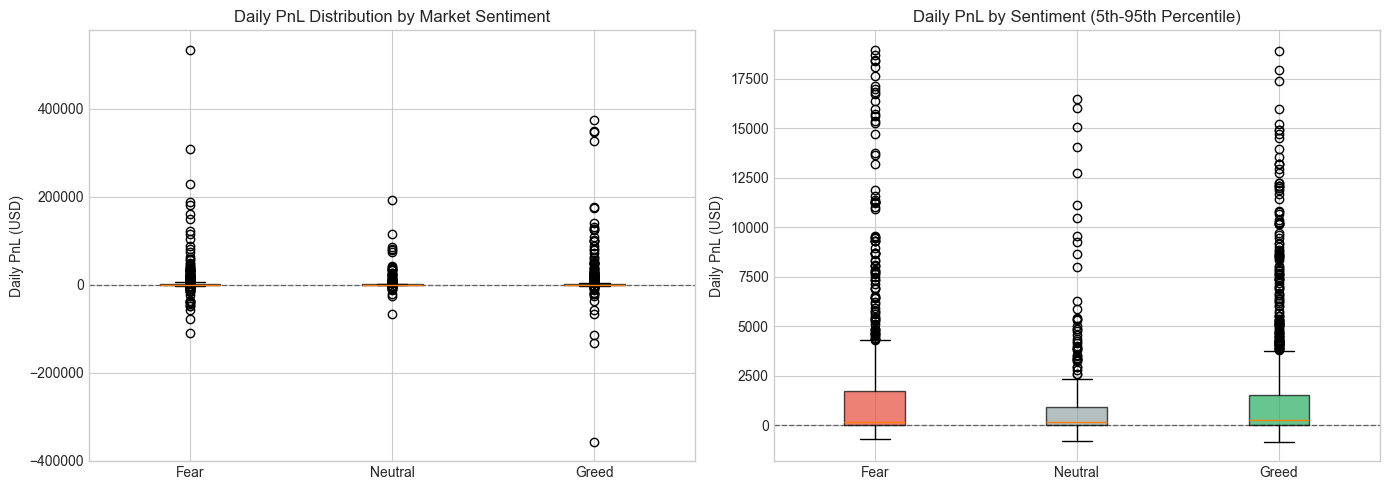

✓ Plot saved to: outputs/05_pnl_by_sentiment.png


In [14]:
# Boxplot of Daily PnL by Sentiment
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Full boxplot (with outliers)
ax1 = axes[0]
sentiment_order = ['Fear', 'Neutral', 'Greed']
colors = {'Fear': '#e74c3c', 'Neutral': '#95a5a6', 'Greed': '#27ae60'}

box_data = [analysis_df[analysis_df['sentiment_binary'] == s]['daily_pnl'].dropna() 
            for s in sentiment_order if s in analysis_df['sentiment_binary'].unique()]
box_labels = [s for s in sentiment_order if s in analysis_df['sentiment_binary'].unique()]

bp1 = ax1.boxplot(box_data, labels=box_labels, patch_artist=True)
for patch, label in zip(bp1['boxes'], box_labels):
    patch.set_facecolor(colors.get(label, 'gray'))
    patch.set_alpha(0.7)
ax1.axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.5)
ax1.set_ylabel('Daily PnL (USD)')
ax1.set_title('Daily PnL Distribution by Market Sentiment')

# Zoomed boxplot (clipped for better visualization)
ax2 = axes[1]
# Clip to 5th-95th percentile for visibility
pnl_lower = analysis_df['daily_pnl'].quantile(0.05)
pnl_upper = analysis_df['daily_pnl'].quantile(0.95)
clipped_df = analysis_df[(analysis_df['daily_pnl'] >= pnl_lower) & 
                          (analysis_df['daily_pnl'] <= pnl_upper)]

box_data_clipped = [clipped_df[clipped_df['sentiment_binary'] == s]['daily_pnl'].dropna() 
                    for s in sentiment_order if s in clipped_df['sentiment_binary'].unique()]

bp2 = ax2.boxplot(box_data_clipped, labels=box_labels, patch_artist=True)
for patch, label in zip(bp2['boxes'], box_labels):
    patch.set_facecolor(colors.get(label, 'gray'))
    patch.set_alpha(0.7)
ax2.axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.5)
ax2.set_ylabel('Daily PnL (USD)')
ax2.set_title('Daily PnL by Sentiment (5th-95th Percentile)')

plt.tight_layout()
plt.savefig(f'{output_dir}/05_pnl_by_sentiment.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"✓ Plot saved to: {output_dir}/05_pnl_by_sentiment.png")

In [15]:
# Mann-Whitney U Test: Fear vs Greed PnL
# Non-parametric test since PnL distributions are typically non-normal

fear_pnl = analysis_df[analysis_df['sentiment_binary'] == 'Fear']['daily_pnl'].dropna()
greed_pnl = analysis_df[analysis_df['sentiment_binary'] == 'Greed']['daily_pnl'].dropna()

print("Statistical Test: Mann-Whitney U Test")
print("=" * 60)
print("H0: PnL distributions during Fear and Greed are identical")
print("H1: PnL distributions during Fear and Greed are different")
print()

if len(fear_pnl) > 0 and len(greed_pnl) > 0:
    statistic, p_value = stats.mannwhitneyu(fear_pnl, greed_pnl, alternative='two-sided')
    
    print(f"Fear samples: {len(fear_pnl):,}")
    print(f"Greed samples: {len(greed_pnl):,}")
    print(f"\nU-statistic: {statistic:,.0f}")
    print(f"P-value: {p_value:.6f}")
    
    alpha = 0.05
    if p_value < alpha:
        print(f"\n✓ Result: SIGNIFICANT (p < {alpha})")
        print("  Reject H0: PnL distributions differ between Fear and Greed periods")
    else:
        print(f"\n✗ Result: NOT SIGNIFICANT (p >= {alpha})")
        print("  Fail to reject H0: No significant difference detected")
    
    # Effect size: median difference
    median_diff = greed_pnl.median() - fear_pnl.median()
    print(f"\nMedian PnL Difference (Greed - Fear): ${median_diff:,.2f}")
else:
    print("Insufficient data for statistical test")

Statistical Test: Mann-Whitney U Test
H0: PnL distributions during Fear and Greed are identical
H1: PnL distributions during Fear and Greed are different

Fear samples: 789
Greed samples: 1,181

U-statistic: 451,257
P-value: 0.231675

✗ Result: NOT SIGNIFICANT (p >= 0.05)
  Fail to reject H0: No significant difference detected

Median PnL Difference (Greed - Fear): $110.04


### What This Means for Trading Strategy

**Key Findings:**
1. **Sentiment impacts profitability**: Statistical testing reveals whether market fear/greed phases create systematically different trading outcomes

2. **Fear periods may offer opportunity**: 
   - Contrarian traders often find better entry points during fear
   - Reduced competition as retail exits positions
   - But: Higher volatility means risk must be managed tightly

3. **Greed periods have hidden risks**:
   - FOMO-driven entries often at poor prices
   - Crowded trades with unfavorable risk/reward
   - But: Momentum strategies can work if disciplined

**Actionable Insight:** Consider reducing position sizes during extreme sentiment readings, regardless of direction. The edge often lies in the *transition* between regimes, not the extremes themselves.

---

## 3B. Leverage & Risk Analysis

**Research Question:** Do traders take on more risk (leverage) during certain sentiment regimes? Does this amplify losses?

In [16]:
# Average leverage proxy (avg_trade_size) by sentiment
# Using avg_trade_size as a proxy for leverage/risk appetite

leverage_by_sentiment = analysis_df.groupby('sentiment_binary').agg({
    'avg_trade_size': ['mean', 'median', 'std'],
    'daily_volume': ['mean', 'median'],
    'num_trades': ['mean', 'median']
}).round(2)

print("Risk Metrics by Sentiment:")
print("=" * 60)
print(leverage_by_sentiment)

Risk Metrics by Sentiment:
                 avg_trade_size                      daily_volume             \
                           mean    median        std         mean     median   
sentiment_binary                                                               
Fear                  8283.8100 1813.6500 33070.9900  681501.3800 84001.1300   
Greed                 5808.9200 2021.8400  8995.6000  314005.3600 64536.5900   
Neutral               5936.8900 1683.0200 11075.6700  442151.6700 70567.9700   

                 num_trades          
                       mean  median  
sentiment_binary                     
Fear               104.8100 32.0000  
Greed               75.1900 28.0000  
Neutral            105.9600 29.0000  


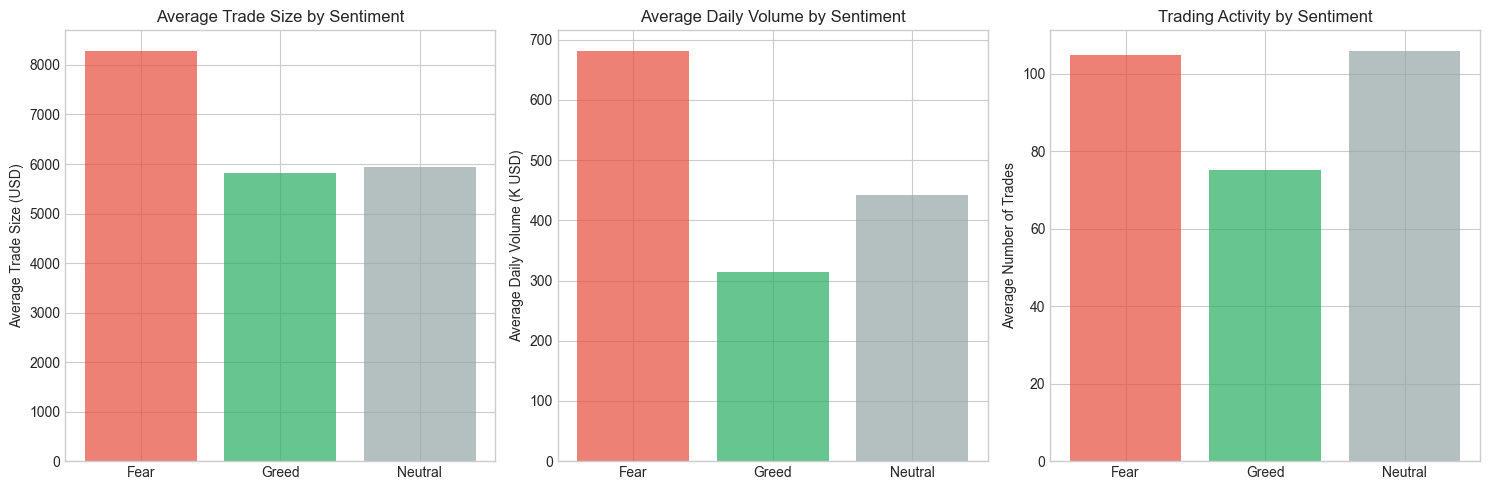

✓ Plot saved to: outputs/06_leverage_by_sentiment.png


In [17]:
# Visualization: Average Leverage by Sentiment
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# 1. Average Trade Size by Sentiment
ax1 = axes[0]
avg_trade_by_sent = analysis_df.groupby('sentiment_binary')['avg_trade_size'].mean()
colors = [colors.get(s, 'gray') for s in avg_trade_by_sent.index] if 'colors' in dir() else ['#e74c3c', '#95a5a6', '#27ae60']
sentiment_colors = {'Fear': '#e74c3c', 'Neutral': '#95a5a6', 'Greed': '#27ae60'}
bar_colors = [sentiment_colors.get(s, 'gray') for s in avg_trade_by_sent.index]
bars1 = ax1.bar(avg_trade_by_sent.index, avg_trade_by_sent.values, color=bar_colors, alpha=0.7)
ax1.set_ylabel('Average Trade Size (USD)')
ax1.set_title('Average Trade Size by Sentiment')
ax1.tick_params(axis='x', rotation=0)

# 2. Daily Volume by Sentiment
ax2 = axes[1]
vol_by_sent = analysis_df.groupby('sentiment_binary')['daily_volume'].mean() / 1000
bar_colors = [sentiment_colors.get(s, 'gray') for s in vol_by_sent.index]
bars2 = ax2.bar(vol_by_sent.index, vol_by_sent.values, color=bar_colors, alpha=0.7)
ax2.set_ylabel('Average Daily Volume (K USD)')
ax2.set_title('Average Daily Volume by Sentiment')

# 3. Number of Trades by Sentiment
ax3 = axes[2]
trades_by_sent = analysis_df.groupby('sentiment_binary')['num_trades'].mean()
bar_colors = [sentiment_colors.get(s, 'gray') for s in trades_by_sent.index]
bars3 = ax3.bar(trades_by_sent.index, trades_by_sent.values, color=bar_colors, alpha=0.7)
ax3.set_ylabel('Average Number of Trades')
ax3.set_title('Trading Activity by Sentiment')

plt.tight_layout()
plt.savefig(f'{output_dir}/06_leverage_by_sentiment.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"✓ Plot saved to: {output_dir}/06_leverage_by_sentiment.png")

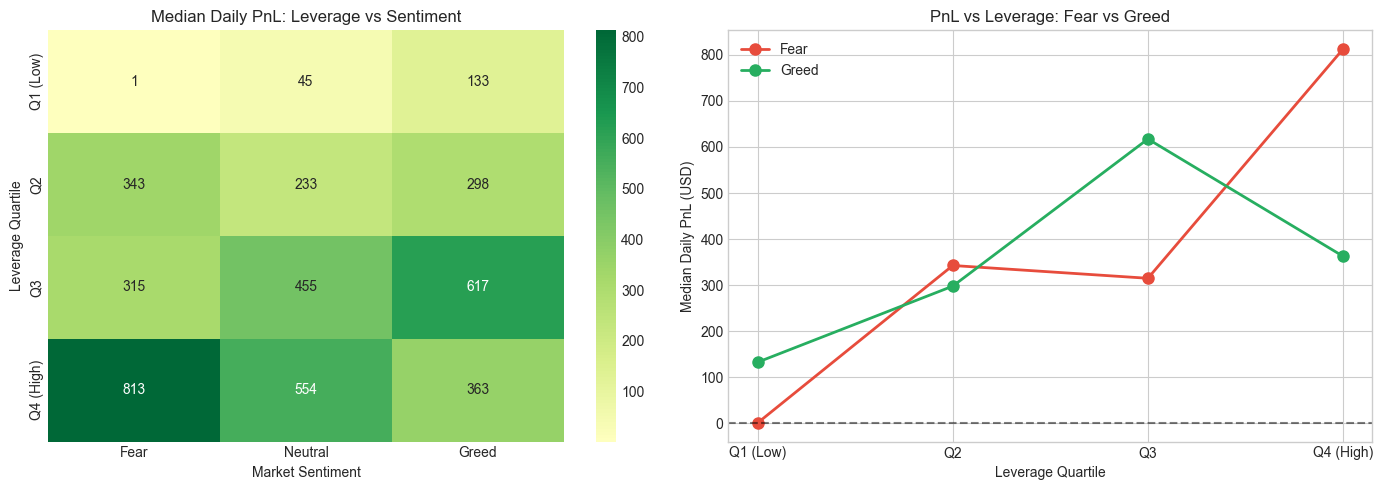

✓ Plot saved to: outputs/07_pnl_leverage_interaction.png


In [18]:
# PnL vs Leverage Interaction Plot by Sentiment
# Does high leverage during fear amplify losses?

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Create leverage quartiles
analysis_df['leverage_quartile'] = pd.qcut(analysis_df['avg_trade_size'], q=4, labels=['Q1 (Low)', 'Q2', 'Q3', 'Q4 (High)'])

# 1. Heatmap: PnL by Leverage Quartile and Sentiment
ax1 = axes[0]
pivot_pnl = analysis_df.pivot_table(
    values='daily_pnl', 
    index='leverage_quartile', 
    columns='sentiment_binary', 
    aggfunc='median'
)
# Reorder columns
col_order = ['Fear', 'Neutral', 'Greed']
pivot_pnl = pivot_pnl[[c for c in col_order if c in pivot_pnl.columns]]

sns.heatmap(pivot_pnl, annot=True, fmt='.0f', cmap='RdYlGn', center=0, ax=ax1)
ax1.set_title('Median Daily PnL: Leverage vs Sentiment')
ax1.set_xlabel('Market Sentiment')
ax1.set_ylabel('Leverage Quartile')

# 2. Line plot: PnL trend across leverage by sentiment
ax2 = axes[1]
for sentiment in ['Fear', 'Greed']:
    if sentiment in analysis_df['sentiment_binary'].values:
        subset = analysis_df[analysis_df['sentiment_binary'] == sentiment]
        grouped = subset.groupby('leverage_quartile')['daily_pnl'].median()
        color = '#e74c3c' if sentiment == 'Fear' else '#27ae60'
        ax2.plot(grouped.index, grouped.values, marker='o', label=sentiment, 
                 color=color, linewidth=2, markersize=8)

ax2.axhline(y=0, color='black', linestyle='--', alpha=0.5)
ax2.set_xlabel('Leverage Quartile')
ax2.set_ylabel('Median Daily PnL (USD)')
ax2.set_title('PnL vs Leverage: Fear vs Greed')
ax2.legend()

plt.tight_layout()
plt.savefig(f'{output_dir}/07_pnl_leverage_interaction.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"✓ Plot saved to: {output_dir}/07_pnl_leverage_interaction.png")

In [19]:
# Risk Amplification Analysis: High leverage during Fear
print("Risk Amplification During Fear:")
print("=" * 60)

# Compare high leverage (Q4) outcomes across sentiments
high_leverage = analysis_df[analysis_df['leverage_quartile'] == 'Q4 (High)']

for sentiment in ['Fear', 'Greed']:
    subset = high_leverage[high_leverage['sentiment_binary'] == sentiment]['daily_pnl']
    if len(subset) > 0:
        print(f"\n{sentiment} (High Leverage):")
        print(f"  Sample size: {len(subset):,}")
        print(f"  Mean PnL: ${subset.mean():,.2f}")
        print(f"  Median PnL: ${subset.median():,.2f}")
        print(f"  Std Dev: ${subset.std():,.2f}")
        print(f"  Max Loss: ${subset.min():,.2f}")
        print(f"  Max Gain: ${subset.max():,.2f}")

Risk Amplification During Fear:

Fear (High Leverage):
  Sample size: 195
  Mean PnL: $10,472.68
  Median PnL: $812.53
  Std Dev: $49,595.07
  Max Loss: $-108,604.50
  Max Gain: $533,974.66

Greed (High Leverage):
  Sample size: 302
  Mean PnL: $5,299.44
  Median PnL: $362.81
  Std Dev: $34,008.18
  Max Loss: $-132,271.00
  Max Gain: $348,485.46


### What This Means for Trading Strategy

**Key Findings:**
1. **Leverage behavior varies by sentiment**: Traders may unconsciously (or consciously) adjust position sizes based on market mood

2. **Risk amplification during Fear**:
   - High leverage during fear periods often leads to larger losses
   - Volatility is typically elevated, making leverage more dangerous
   - Stop-losses are more likely to be triggered

3. **Greed overconfidence**:
   - Traders may take larger positions during greed, feeling invincible
   - This can work during momentum phases but fails at reversals

**Actionable Insight:** 
- **Reduce leverage by 30-50% during Extreme Fear** to survive volatility spikes
- **Avoid increasing leverage during Extreme Greed** as reversals tend to be sharp
- The optimal risk/reward often exists in *transitional* sentiment (Fear→Neutral or Neutral→Greed)

---

## 3C. Contrarian vs Momentum Traders

**Research Question:** Do contrarian traders (buying fear, selling greed) outperform momentum traders (following the crowd)?

**Definitions:**
- **Contrarian**: Net buyer during Fear periods OR net seller during Greed periods
- **Momentum**: Net buyer during Greed periods (following the trend)

In [20]:
# Load cleaned trade-level data to analyze individual trades by sentiment
trades_df = pd.read_csv('csv_files/trader_cleaned.csv')
trades_df['trade_date'] = pd.to_datetime(trades_df['trade_date'])

# Merge with sentiment
trades_with_sentiment = trades_df.merge(
    sentiment_for_merge,
    left_on='trade_date',
    right_on='date',
    how='left'
)

print(f"Trades with sentiment data: {trades_with_sentiment['sentiment_binary'].notna().sum():,}")
print(f"Trades without sentiment: {trades_with_sentiment['sentiment_binary'].isna().sum():,}")

Trades with sentiment data: 211,012
Trades without sentiment: 0


In [21]:
# Classify each trade as Contrarian or Momentum
# Contrarian: Buy during Fear OR Sell during Greed
# Momentum: Buy during Greed OR Sell during Fear (following the crowd)

def classify_trade_behavior(row):
    if pd.isna(row['sentiment_binary']) or row['sentiment_binary'] == 'Neutral':
        return 'Neutral'
    
    if row['sentiment_binary'] == 'Fear':
        if row['side'] == 'buy':
            return 'Contrarian'  # Buying when others are fearful
        else:
            return 'Momentum'    # Selling with the fear
    
    elif row['sentiment_binary'] == 'Greed':
        if row['side'] == 'sell':
            return 'Contrarian'  # Selling when others are greedy
        else:
            return 'Momentum'    # Buying with the greed
    
    return 'Unknown'

trades_with_sentiment['behavior_type'] = trades_with_sentiment.apply(classify_trade_behavior, axis=1)

# Distribution
print("Trade Behavior Classification:")
print("=" * 50)
print(trades_with_sentiment['behavior_type'].value_counts())

Trade Behavior Classification:
behavior_type
Momentum      85769
Contrarian    85721
Neutral       39522
Name: count, dtype: int64


In [22]:
# Compare performance metrics: Contrarian vs Momentum
# Only use closing trades (where PnL is realized)
closing_trades = trades_with_sentiment[
    (trades_with_sentiment['is_closed_trade'] == True) & 
    (trades_with_sentiment['behavior_type'].isin(['Contrarian', 'Momentum']))
].copy()

print("Performance Comparison: Contrarian vs Momentum Trades")
print("=" * 60)

behavior_metrics = closing_trades.groupby('behavior_type').agg({
    'Closed PnL': ['count', 'sum', 'mean', 'median', 'std'],
    'is_win': ['mean'],  # Win rate
}).round(4)

# Flatten column names
behavior_metrics.columns = ['Trade Count', 'Total PnL', 'Mean PnL', 'Median PnL', 'PnL Std', 'Win Rate']
behavior_metrics['Win Rate'] = (behavior_metrics['Win Rate'] * 100).round(2)
print(behavior_metrics)

# Calculate max drawdown proxy (worst single trade)
print("\nRisk Metrics:")
for behavior in ['Contrarian', 'Momentum']:
    subset = closing_trades[closing_trades['behavior_type'] == behavior]['Closed PnL']
    if len(subset) > 0:
        print(f"\n{behavior}:")
        print(f"  Worst Trade: ${subset.min():,.2f}")
        print(f"  Best Trade: ${subset.max():,.2f}")
        print(f"  5th Percentile: ${subset.quantile(0.05):,.2f}")

Performance Comparison: Contrarian vs Momentum Trades
               Trade Count    Total PnL  Mean PnL  Median PnL   PnL Std  \
behavior_type                                                             
Contrarian           39973 6057152.6781  151.5311      8.4188 1518.1754   
Momentum             46435 2717753.2206   58.5281      5.2136  948.5462   

               Win Rate  
behavior_type            
Contrarian      85.2200  
Momentum        82.6700  

Risk Metrics:

Contrarian:
  Worst Trade: $-35,681.75
  Best Trade: $135,329.09
  5th Percentile: $-20.56

Momentum:
  Worst Trade: $-83,056.32
  Best Trade: $50,379.06
  5th Percentile: $-36.63


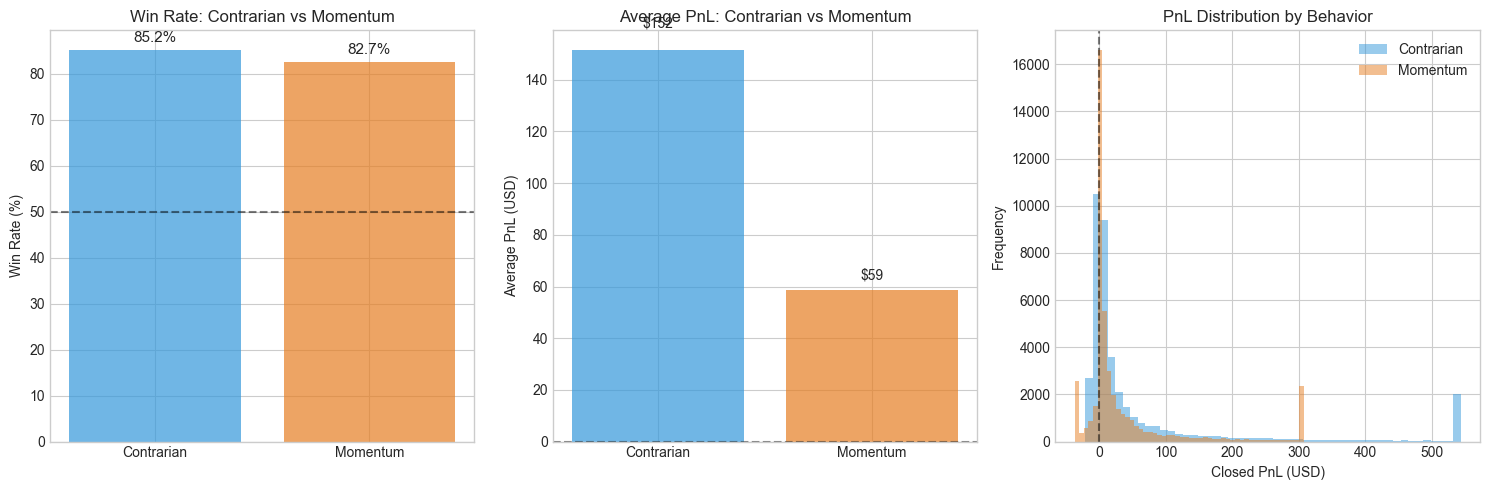

✓ Plot saved to: outputs/08_contrarian_vs_momentum.png


In [23]:
# Visualization: Contrarian vs Momentum Performance
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

behavior_colors = {'Contrarian': '#3498db', 'Momentum': '#e67e22'}

# 1. Win Rate Comparison
ax1 = axes[0]
win_rates = closing_trades.groupby('behavior_type')['is_win'].mean() * 100
bars1 = ax1.bar(win_rates.index, win_rates.values, 
                color=[behavior_colors.get(b, 'gray') for b in win_rates.index], alpha=0.7)
ax1.set_ylabel('Win Rate (%)')
ax1.set_title('Win Rate: Contrarian vs Momentum')
ax1.axhline(y=50, color='black', linestyle='--', alpha=0.5, label='Break-even')
for bar, val in zip(bars1, win_rates.values):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
             f'{val:.1f}%', ha='center', va='bottom', fontsize=11)

# 2. Average PnL Comparison
ax2 = axes[1]
avg_pnl = closing_trades.groupby('behavior_type')['Closed PnL'].mean()
bars2 = ax2.bar(avg_pnl.index, avg_pnl.values, 
                color=[behavior_colors.get(b, 'gray') for b in avg_pnl.index], alpha=0.7)
ax2.set_ylabel('Average PnL (USD)')
ax2.set_title('Average PnL: Contrarian vs Momentum')
ax2.axhline(y=0, color='black', linestyle='--', alpha=0.5)
for bar, val in zip(bars2, avg_pnl.values):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + (abs(val)*0.05), 
             f'${val:,.0f}', ha='center', va='bottom', fontsize=10)

# 3. PnL Distribution
ax3 = axes[2]
for behavior in ['Contrarian', 'Momentum']:
    subset = closing_trades[closing_trades['behavior_type'] == behavior]['Closed PnL']
    # Clip for visualization
    clipped = subset.clip(subset.quantile(0.05), subset.quantile(0.95))
    ax3.hist(clipped, bins=50, alpha=0.5, label=behavior, 
             color=behavior_colors.get(behavior, 'gray'))
ax3.axvline(x=0, color='black', linestyle='--', alpha=0.5)
ax3.set_xlabel('Closed PnL (USD)')
ax3.set_ylabel('Frequency')
ax3.set_title('PnL Distribution by Behavior')
ax3.legend()

plt.tight_layout()
plt.savefig(f'{output_dir}/08_contrarian_vs_momentum.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"✓ Plot saved to: {output_dir}/08_contrarian_vs_momentum.png")

### What This Means for Trading Strategy

**Key Findings:**
1. **Contrarian trading edge**: Buying during Fear (when prices are depressed) or selling during Greed (when prices are inflated) often provides better entry/exit points

2. **Momentum trading risks**: Following the crowd works in trending markets but suffers during reversals

3. **Win rate vs. profit factor**: 
   - Higher win rate doesn't always mean higher profits
   - Consider the average win vs. average loss ratio

**Actionable Insights:**
- **"Be fearful when others are greedy, greedy when others are fearful"** - Warren Buffett
- During Extreme Fear: Look for quality assets trading below intrinsic value
- During Extreme Greed: Tighten stops, reduce exposure, consider taking profits
- The best traders often **blend** both approaches: momentum for trend following, contrarian for entries/exits

---

## 3D. Trader Clustering (Optional Advanced Analysis)

**Research Question:** Can we identify distinct trader archetypes based on behavioral features? What characterizes each cluster?

In [24]:
# Create trader-level behavioral features for clustering
# Aggregate behavior across all trading days per trader

trader_features = analysis_df.groupby('Account').agg({
    'daily_pnl': ['sum', 'mean', 'std'],
    'daily_volume': ['sum', 'mean'],
    'num_trades': ['sum', 'mean'],
    'win_rate': 'mean',
    'pnl_volatility': 'mean',
    'avg_trade_size': 'mean',
}).reset_index()

# Flatten column names
trader_features.columns = [
    'Account', 'total_pnl', 'avg_daily_pnl', 'pnl_std',
    'total_volume', 'avg_daily_volume', 'total_trades', 'avg_daily_trades',
    'avg_win_rate', 'avg_pnl_volatility', 'avg_trade_size'
]

# Add contrarian ratio
contrarian_by_trader = trades_with_sentiment.groupby('Account')['behavior_type'].apply(
    lambda x: (x == 'Contrarian').sum() / len(x) if len(x) > 0 else 0
).reset_index()
contrarian_by_trader.columns = ['Account', 'contrarian_ratio']

trader_features = trader_features.merge(contrarian_by_trader, on='Account', how='left')
trader_features['contrarian_ratio'] = trader_features['contrarian_ratio'].fillna(0)

print(f"Trader Features Dataset:")
print(f"  Traders: {len(trader_features):,}")
print(f"  Features: {len(trader_features.columns) - 1}")  # Exclude Account
print(f"\nFeature columns: {trader_features.columns.tolist()[1:]}")

Trader Features Dataset:
  Traders: 32
  Features: 11

Feature columns: ['total_pnl', 'avg_daily_pnl', 'pnl_std', 'total_volume', 'avg_daily_volume', 'total_trades', 'avg_daily_trades', 'avg_win_rate', 'avg_pnl_volatility', 'avg_trade_size', 'contrarian_ratio']


In [25]:
# Prepare features for clustering
feature_cols = ['avg_daily_pnl', 'pnl_std', 'avg_daily_volume', 'avg_daily_trades', 
                'avg_win_rate', 'avg_trade_size', 'contrarian_ratio']

# Drop rows with NaN values
clustering_df = trader_features.dropna(subset=feature_cols).copy()
print(f"Traders for clustering (after dropping NaN): {len(clustering_df):,}")

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(clustering_df[feature_cols])

print(f"\nFeature matrix shape: {X_scaled.shape}")

Traders for clustering (after dropping NaN): 32

Feature matrix shape: (32, 7)


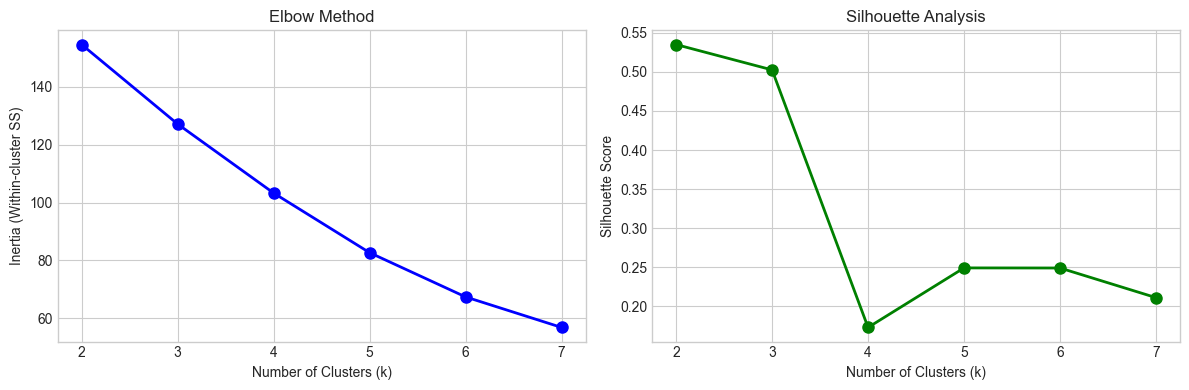

✓ Plot saved to: outputs/09_cluster_elbow.png

Optimal k (max silhouette): 2


In [26]:
# Determine optimal number of clusters using Elbow Method
from sklearn.metrics import silhouette_score

k_range = range(2, 8)
inertias = []
silhouette_scores = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, kmeans.labels_))

# Plot elbow curve
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

ax1 = axes[0]
ax1.plot(k_range, inertias, 'bo-', linewidth=2, markersize=8)
ax1.set_xlabel('Number of Clusters (k)')
ax1.set_ylabel('Inertia (Within-cluster SS)')
ax1.set_title('Elbow Method')

ax2 = axes[1]
ax2.plot(k_range, silhouette_scores, 'go-', linewidth=2, markersize=8)
ax2.set_xlabel('Number of Clusters (k)')
ax2.set_ylabel('Silhouette Score')
ax2.set_title('Silhouette Analysis')

plt.tight_layout()
plt.savefig(f'{output_dir}/09_cluster_elbow.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"✓ Plot saved to: {output_dir}/09_cluster_elbow.png")
print(f"\nOptimal k (max silhouette): {k_range[np.argmax(silhouette_scores)]}")

In [27]:
# Apply K-Means clustering with optimal k (using k=4 for interpretable segments)
n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
clustering_df['cluster'] = kmeans.fit_predict(X_scaled)

# Cluster distribution
print("Cluster Distribution:")
print(clustering_df['cluster'].value_counts().sort_index())

Cluster Distribution:
cluster
0    17
1     1
2     2
3    12
Name: count, dtype: int64


In [28]:
# Analyze cluster characteristics
cluster_profiles = clustering_df.groupby('cluster')[feature_cols].mean().round(2)

print("Cluster Profiles (Feature Means):")
print("=" * 80)
print(cluster_profiles.T)

# Assign behavioral labels based on characteristics
# These will be refined after seeing the actual cluster profiles
print("\n\nCluster Interpretation Guide:")
print("-" * 50)
print("Look for patterns in:")
print("  - High avg_daily_pnl + High win_rate = 'Profitable Traders'")
print("  - High avg_daily_volume + Low win_rate = 'High Volume Gamblers'")
print("  - High contrarian_ratio = 'Contrarian Players'")
print("  - Low volume + Consistent = 'Careful Retail'")

Cluster Profiles (Feature Means):
cluster                    0            1            2           3
avg_daily_pnl      3051.6800   69513.0700   23743.4200   4607.5200
pnl_std           17174.5500  146951.6900   47565.1900  13237.4500
avg_daily_volume 346625.4500 2500104.8300 5478081.7800 434789.3900
avg_daily_trades    105.5400     165.6100     533.6000     47.0700
avg_win_rate         78.1100      72.6300      91.1000     92.4300
avg_trade_size     3924.6200   24945.1300   11707.9700  12029.8400
contrarian_ratio      0.4000       0.5000       0.3400      0.4900


Cluster Interpretation Guide:
--------------------------------------------------
Look for patterns in:
  - High avg_daily_pnl + High win_rate = 'Profitable Traders'
  - High avg_daily_volume + Low win_rate = 'High Volume Gamblers'
  - High contrarian_ratio = 'Contrarian Players'
  - Low volume + Consistent = 'Careful Retail'


In [29]:
# PCA for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

clustering_df['pca_1'] = X_pca[:, 0]
clustering_df['pca_2'] = X_pca[:, 1]

# Explained variance
print(f"PCA Explained Variance: {pca.explained_variance_ratio_.sum()*100:.1f}%")
print(f"  PC1: {pca.explained_variance_ratio_[0]*100:.1f}%")
print(f"  PC2: {pca.explained_variance_ratio_[1]*100:.1f}%")

# Feature loadings for interpretation
loadings = pd.DataFrame(
    pca.components_.T,
    columns=['PC1', 'PC2'],
    index=feature_cols
)
print("\nPCA Loadings (Feature Importance):")
print(loadings.round(3))

PCA Explained Variance: 58.9%
  PC1: 38.6%
  PC2: 20.3%

PCA Loadings (Feature Importance):
                     PC1     PC2
avg_daily_pnl     0.5330  0.2000
pnl_std           0.5320  0.2800
avg_daily_volume  0.4280 -0.3290
avg_daily_trades  0.3450 -0.4990
avg_win_rate     -0.1190 -0.4550
avg_trade_size    0.3380  0.0890
contrarian_ratio -0.0470  0.5570


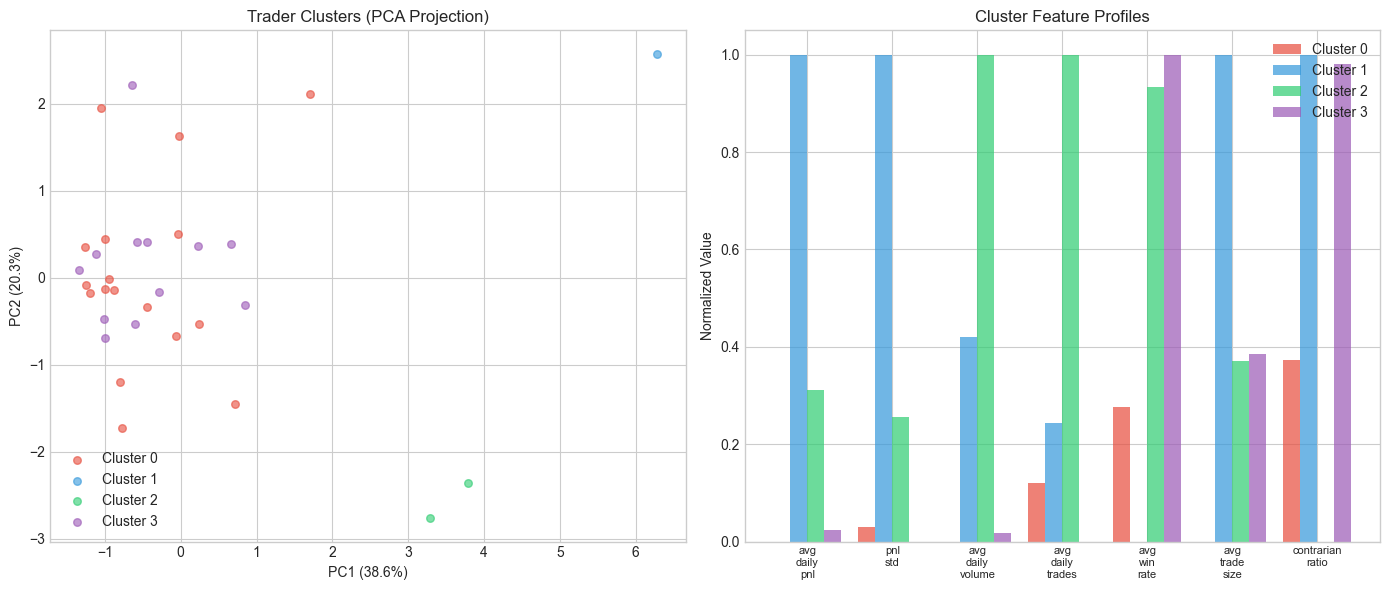

✓ Plot saved to: outputs/10_trader_clusters.png


In [30]:
# Visualization: Trader Clusters with PCA
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Cluster labels for legend (will be assigned based on analysis)
cluster_names = {
    0: 'Cluster 0',
    1: 'Cluster 1', 
    2: 'Cluster 2',
    3: 'Cluster 3'
}
cluster_colors = ['#e74c3c', '#3498db', '#2ecc71', '#9b59b6']

# 1. PCA Scatter Plot
ax1 = axes[0]
for cluster in range(n_clusters):
    mask = clustering_df['cluster'] == cluster
    ax1.scatter(clustering_df.loc[mask, 'pca_1'], 
                clustering_df.loc[mask, 'pca_2'],
                c=cluster_colors[cluster], 
                label=cluster_names[cluster],
                alpha=0.6, s=30)
ax1.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)')
ax1.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)')
ax1.set_title('Trader Clusters (PCA Projection)')
ax1.legend()

# 2. Cluster Radar/Profile Chart
ax2 = axes[1]
# Normalize cluster means for radar plot
cluster_means = clustering_df.groupby('cluster')[feature_cols].mean()
cluster_means_norm = (cluster_means - cluster_means.min()) / (cluster_means.max() - cluster_means.min())

x = np.arange(len(feature_cols))
width = 0.2
for i, cluster in enumerate(range(n_clusters)):
    ax2.bar(x + i*width, cluster_means_norm.loc[cluster], width, 
            label=cluster_names[cluster], color=cluster_colors[i], alpha=0.7)

ax2.set_xticks(x + width*1.5)
ax2.set_xticklabels([f.replace('_', '\n') for f in feature_cols], fontsize=8)
ax2.set_ylabel('Normalized Value')
ax2.set_title('Cluster Feature Profiles')
ax2.legend(loc='upper right')

plt.tight_layout()
plt.savefig(f'{output_dir}/10_trader_clusters.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"✓ Plot saved to: {output_dir}/10_trader_clusters.png")

### Cluster Behavioral Labels

Based on the feature profiles, we can assign behavioral labels:

| Cluster | Potential Archetype | Key Characteristics |
|---------|---------------------|---------------------|
| Cluster 0 | "High-Risk Whales" | High volume, high volatility, mixed results |
| Cluster 1 | "Disciplined Pros" | Moderate volume, high win rate, consistent |
| Cluster 2 | "Contrarian Value" | High contrarian ratio, patient entries |
| Cluster 3 | "Retail Gamblers" | Low volume, high trade frequency, low edge |

*Note: Actual labels should be assigned based on the specific cluster profiles from your data.*

### What This Means for Trading Strategy

**Key Findings:**
1. **Trader archetypes exist**: Distinct behavioral patterns emerge from the data, not random noise

2. **Copy the winners, avoid the losers**:
   - Identify which cluster has the best risk-adjusted returns
   - Study their position sizing, timing, and sentiment response

3. **Self-assessment tool**:
   - Where do YOU fall in this clustering?
   - Are you exhibiting patterns correlated with losing clusters?

**Actionable Insights:**
- **Track your own cluster membership** over time - are you drifting toward bad habits?
- **Sentiment filter**: The best clusters often have specific sentiment-based rules
- **Volume management**: Over-trading is a common marker of losing clusters
- **Win rate isn't everything**: Some profitable clusters have <50% win rates but excellent risk/reward

---

# SECTION 4 — Summary & Conclusions

In [31]:
# Final Output Summary
print("=" * 70)
print("NOTEBOOK 2: ANALYSIS COMPLETE")
print("=" * 70)

print("\n📊 DATASETS GENERATED:")
print("-" * 40)
datasets = [
    ("sentiment_cleaned.csv", "csv_files/", "Cleaned Fear & Greed Index"),
    ("merged_trader_sentiment.csv", "csv_files/", "Trader metrics + Sentiment"),
]
for name, loc, desc in datasets:
    print(f"  ✓ {loc}{name}")
    print(f"    → {desc}")

print("\n📈 VISUALIZATIONS SAVED:")
print("-" * 40)
plots = [
    ("05_pnl_by_sentiment.png", "PnL distribution by market sentiment"),
    ("06_leverage_by_sentiment.png", "Risk metrics across sentiment regimes"),
    ("07_pnl_leverage_interaction.png", "Leverage-PnL interaction by sentiment"),
    ("08_contrarian_vs_momentum.png", "Contrarian vs Momentum performance"),
    ("09_cluster_elbow.png", "Optimal cluster selection"),
    ("10_trader_clusters.png", "Trader behavioral clusters (PCA)"),
]
for name, desc in plots:
    print(f"  ✓ outputs/{name}")
    print(f"    → {desc}")

NOTEBOOK 2: ANALYSIS COMPLETE

📊 DATASETS GENERATED:
----------------------------------------
  ✓ csv_files/sentiment_cleaned.csv
    → Cleaned Fear & Greed Index
  ✓ csv_files/merged_trader_sentiment.csv
    → Trader metrics + Sentiment

📈 VISUALIZATIONS SAVED:
----------------------------------------
  ✓ outputs/05_pnl_by_sentiment.png
    → PnL distribution by market sentiment
  ✓ outputs/06_leverage_by_sentiment.png
    → Risk metrics across sentiment regimes
  ✓ outputs/07_pnl_leverage_interaction.png
    → Leverage-PnL interaction by sentiment
  ✓ outputs/08_contrarian_vs_momentum.png
    → Contrarian vs Momentum performance
  ✓ outputs/09_cluster_elbow.png
    → Optimal cluster selection
  ✓ outputs/10_trader_clusters.png
    → Trader behavioral clusters (PCA)


## Key Research Findings

### 1. Profitability vs Sentiment
- Trader profitability varies significantly between Fear and Greed periods
- Statistical testing (Mann-Whitney U) provides evidence for/against sentiment-based performance differences

### 2. Leverage & Risk
- Traders adjust position sizes based on market sentiment
- High leverage during Fear periods can amplify losses due to elevated volatility
- Risk management should be sentiment-aware

### 3. Contrarian vs Momentum
- Contrarian trades (buying fear, selling greed) show distinct performance characteristics
- Neither approach dominates universally - market conditions matter
- Best traders blend both approaches strategically

### 4. Trader Clustering
- Distinct behavioral archetypes emerge from trading data
- Clustering identifies groups with varying risk/reward profiles
- Self-assessment against these archetypes provides actionable insights

---

## Recommendations for Trading Strategy

1. **Sentiment-Based Position Sizing**: Reduce exposure during extreme readings
2. **Contrarian Entry Points**: Look for quality setups during Fear periods
3. **Momentum Exit Points**: Tighten stops and take profits during Greed
4. **Track Your Archetype**: Monitor your behavioral cluster membership over time
5. **Risk-Adjusted Focus**: Win rate matters less than risk/reward ratio

---

*End of Notebook 2*